# AQI Prediction


In [17]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from scipy.stats import uniform, randint
import pickle


In [9]:
df = pd.read_csv("/content/dailyDataAQI.csv")

In [10]:
df.head()

,Date,Site,State,Latitude,Longitude,PM2.5,PM10,NH3,SO2,AQI
0,2022-01-01,Alipur,Delhi,28.815691,77.15301,222.29,354.54,3.12,7.67,480
1,2022-01-02,Alipur,Delhi,28.815691,77.15301,233.46,346.61,3.41,12.78,474
2,2022-01-03,Alipur,Delhi,28.815691,77.15301,235.69,370.61,3.49,8.48,492
3,2022-01-04,Alipur,Delhi,28.815691,77.15301,231.05,364.12,3.53,7.65,487
4,2022-01-05,Alipur,Delhi,28.815691,77.15301,243.12,324.54,4.02,4.87,457


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28098 entries, 0 to 28097
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       28098 non-null  object 
 1   Site       28098 non-null  object 
 2   State      28098 non-null  object 
 3   Latitude   28098 non-null  float64
 4   Longitude  28098 non-null  float64
 5   PM2.5      28098 non-null  float64
 6   PM10       28098 non-null  float64
 7   NH3        28098 non-null  float64
 8   SO2        28098 non-null  float64
 9   AQI        28098 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 2.1+ MB


In [13]:
df.drop(['Site',"State"],axis=1,inplace =True)

In [14]:
df.head()

,Date,Latitude,Longitude,PM2.5,PM10,NH3,SO2,AQI
0,2022-01-01,28.815691,77.15301,222.29,354.54,3.12,7.67,480
1,2022-01-02,28.815691,77.15301,233.46,346.61,3.41,12.78,474
2,2022-01-03,28.815691,77.15301,235.69,370.61,3.49,8.48,492
3,2022-01-04,28.815691,77.15301,231.05,364.12,3.53,7.65,487
4,2022-01-05,28.815691,77.15301,243.12,324.54,4.02,4.87,457


**EDA**

In [16]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract Year, Month, and Day
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Drop the original 'Date' column if needed
df = df.drop('Date', axis=1)

print(df)

        Latitude  Longitude   PM2.5    PM10    NH3    SO2  AQI  Year  Month  \
0      28.815691  77.153010  222.29  354.54   3.12   7.67  480  2022      1   
1      28.815691  77.153010  233.46  346.61   3.41  12.78  474  2022      1   
2      28.815691  77.153010  235.69  370.61   3.49   8.48  492  2022      1   
3      28.815691  77.153010  231.05  364.12   3.53   7.65  487  2022      1   
4      28.815691  77.153010  243.12  324.54   4.02   4.87  457  2022      1   
...          ...        ...     ...     ...    ...    ...  ...   ...    ...   
28093  28.699793  77.165453  156.47  358.33  28.88  20.93  483  2023     10   
28094  28.699793  77.165453  213.66  492.09  27.80  18.13  586  2023     10   
28095  28.699793  77.165453  221.52  483.46  28.34  18.52  579  2023     10   
28096  28.699793  77.165453  254.54  499.36  28.88  19.88  591  2023     10   
28097  28.699793  77.165453  295.00  589.00  26.70  11.30  660  2023     10   

       Day  
0        1  
1        2  
2        3  

In [18]:
df.describe()

,Latitude,Longitude,PM2.5,PM10,NH3,SO2,AQI,Year,Month,Day
count,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000,28098.000000
mean,28.625987,77.214526,85.160494,193.822541,39.850803,11.061647,325.097409,2022.454410,6.071749,15.717489
std,0.140576,0.133181,65.527677,111.006684,26.982905,9.600807,130.031422,0.497926,3.237210,8.795420
min,28.341925,76.925400,0.061224,0.275510,0.006633,0.005525,0.000000,2022.000000,1.000000,1.000000
25%,28.557054,77.131023,37.410000,106.225000,23.650000,4.650000,254.000000,2022.000000,3.000000,8.000000
50%,28.632526,77.235783,67.320000,178.090000,35.410000,8.570000,344.000000,2022.000000,6.000000,16.000000
75%,28.695381,77.315260,113.117500,262.777500,49.440000,15.057500,409.000000,2023.000000,9.000000,23.000000
max,29.027200,77.482000,607.550000,823.000000,349.080000,171.310000,840.000000,2023.000000,12.000000,31.000000


In [19]:
# Define features and target
X = df.drop('AQI', axis=1)
y = df['AQI']

In [20]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

**Models Selection**

In [22]:
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Lasso': {
        'model': Lasso(random_state=42),
        'params': {
            'alpha': uniform(0.01, 100)
        }
    },
    'Ridge': {
        'model': Ridge(random_state=42),
        'params': {
            'alpha': uniform(0.01, 100)
        }
    },
    'ElasticNet': {
        'model': ElasticNet(random_state=42),
        'params': {
            'alpha': uniform(0.01, 100),
            'l1_ratio': uniform(0.1, 0.9)
        }
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'max_depth': [None, 3, 5, 7, 10],
            'min_samples_split': randint(2, 11),
            'min_samples_leaf': randint(1, 5)
        }
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': randint(50, 201),
            'max_depth': [None, 3, 5, 7, 10],
            'min_samples_split': randint(2, 11),
            'min_samples_leaf': randint(1, 5)
        }
    },
    'AdaBoostRegressor': {
        'model': AdaBoostRegressor(random_state=42),
        'params': {
            'n_estimators': randint(50, 201),
            'learning_rate': uniform(0.01, 1.0)
        }
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': randint(50, 201),
            'learning_rate': uniform(0.01, 0.2),
            'max_depth': randint(3, 8)
        }
    },
    'XGBRegressor': {
        'model': XGBRegressor(random_state=42),
        'params': {
            'n_estimators': randint(50, 201),
            'learning_rate': uniform(0.01, 0.2),
            'max_depth': randint(3, 8)
        }
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': randint(3, 10),
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    },

}

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
# Function to calculate adjusted R^2 score
def adjusted_r2_score(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

In [25]:
# Function to evaluate a model
def evaluate_model(model, params, X_train, y_train, X_test, y_test):
    grid_search = RandomizedSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
    grid_search.fit(X_train, y_train.values.ravel())

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    n = X_test.shape[0]
    k = X_test.shape[1]
    adj_r2 = adjusted_r2_score(r2, n, k)

    mse = mean_squared_error(y_test, y_pred)

    print(f"Model: {best_model}")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    print(f"Adjusted R^2 Score: {adj_r2}")
    print("=======================================")

    return best_model, adj_r2

**Models Training**

In [26]:
# Dictionaries to store adjusted R² scores and best models
adjusted_r2_scores = {}
all_models = {}

for model_name, model_info in models.items():
    print(f"Evaluating and Training {model_name}...")
    best_model, adj_r2 = evaluate_model(model_info['model'], model_info['params'], X_train, y_train, X_test, y_test)
    adjusted_r2_scores[model_name] = adj_r2
    all_models[model_name] = best_model

    # Save the model
    with open(f"{model_name}.pkl", 'wb') as file:
        pickle.dump(best_model, file)
    print(f"Model {model_name} saved to {model_name}.pkl")

Evaluating and Training LinearRegression...
Model: LinearRegression()
Best parameters: {}
Mean Squared Error: 1747.2599213503897
R^2 Score: 0.8946104910976505
Adjusted R^2 Score: 0.8944414170191974
Model LinearRegression saved to LinearRegression.pkl
Evaluating and Training Lasso...
Model: Lasso(alpha=5.818361216819946, random_state=42)
Best parameters: {'alpha': 5.818361216819946}
Mean Squared Error: 1831.938333709263
R^2 Score: 0.8895029417376016
Adjusted R^2 Score: 0.889325673729694
Model Lasso saved to Lasso.pkl
Evaluating and Training Ridge...
Model: Ridge(alpha=5.818361216819946, random_state=42)
Best parameters: {'alpha': 5.818361216819946}
Mean Squared Error: 1747.2438329974716
R^2 Score: 0.8946114614991302
Adjusted R^2 Score: 0.8944423889774711
Model Ridge saved to Ridge.pkl
Evaluating and Training ElasticNet...
Model: ElasticNet(alpha=2.0684494295802445, l1_ratio=0.9729188669457949,
           random_state=42)
Best parameters: {'alpha': 2.0684494295802445, 'l1_ratio': 0.97291

**Models Evaluation**

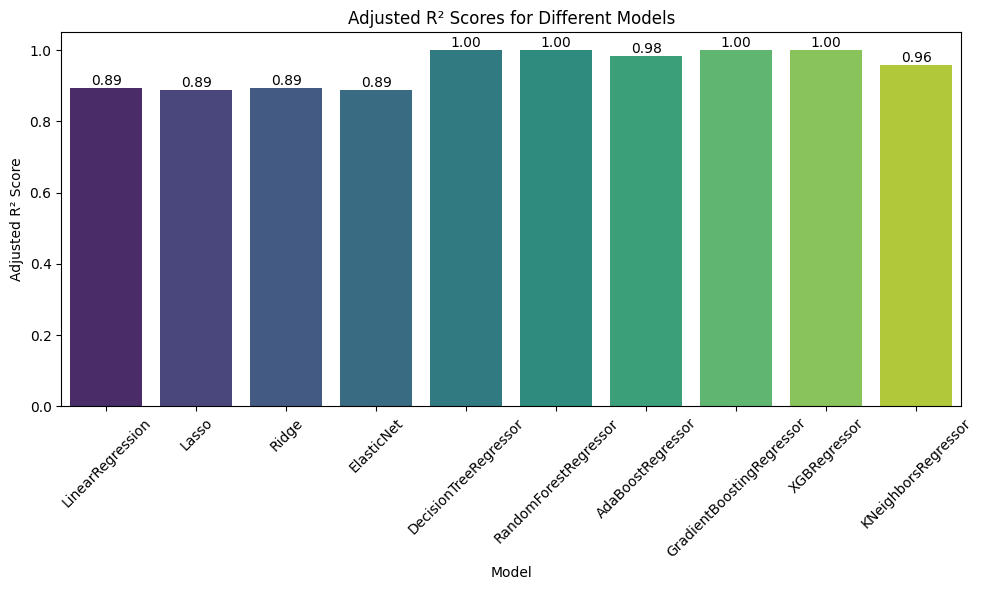

In [28]:
# Plotting the adjusted R² scores
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=list(adjusted_r2_scores.keys()), y=list(adjusted_r2_scores.values()), palette='viridis')

# Adding data labels
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{height:.2f}', (bar.get_x() + bar.get_width() / 2., height),
                  ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                  textcoords='offset points')

plt.xlabel('Model')
plt.ylabel('Adjusted R² Score')
plt.title('Adjusted R² Scores for Different Models')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()
